# plot

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import greatpy as great 
import bindome as bd 

import matplotlib.pyplot as plt 
import seaborn as sns 

import pandas as pd 
import numpy as np 

import time

In [3]:
test = "../data/tests/test_data/input/01_random.bed"
regdom = "../data/human/hg38/regulatory_domain.bed"

## Count plot

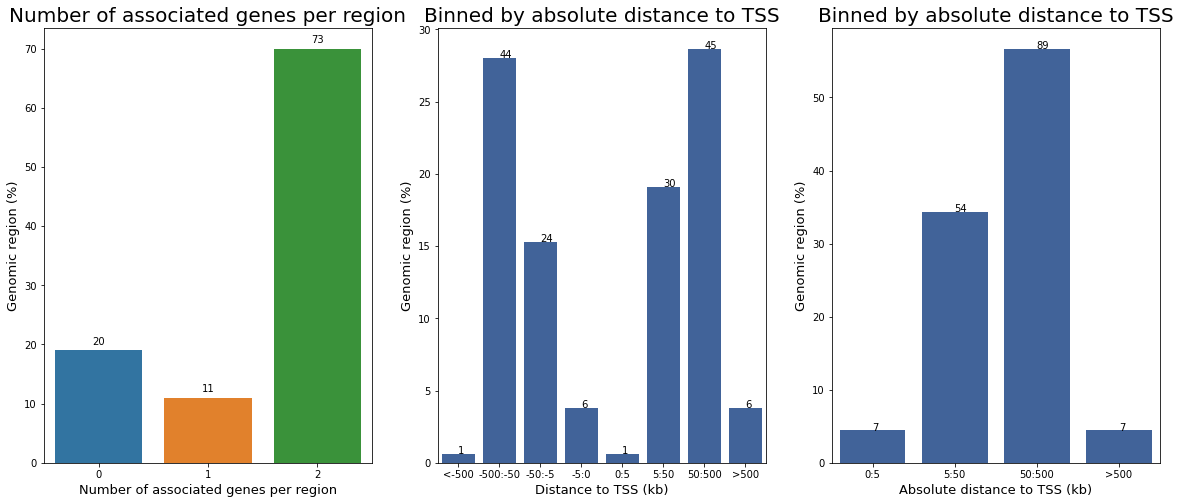

In [4]:
fig,ax = plt.subplots(1,3,figsize=(20,8))
great.pl.graph_nb_asso_per_peaks(test,regdom,ax[0])
great.pl.graph_dist_tss(test,regdom,ax[1])
great.pl.graph_absolute_dist_tss(test,regdom,ax[2])
plt.show()

## Dotplot

In [5]:
enrichment = great.tl.GREAT.enrichment(
    test,
    regdom,
    "../data/human/hg38/chr_size.bed", 
    "../data/human/ontologies.csv"
)

In [6]:
enrichment

,go_term,binom_p_value,binom_fold_enrichment,hypergeom_p_value,hypergeometric_fold_enrichment,intersection_size,recall
GO:0045887,positive regulation of synaptic growth at neur...,5.20389e-13,2.18004e+05,3.08889e-03,3.23741e+02,4,4.00000e+00
GO:0044721,"protein import into peroxisome matrix, substra...",4.84198e-10,3.94065e+04,3.08889e-03,3.23741e+02,4,4.00000e+00
GO:0036250,peroxisome transport along microtubule,4.84198e-10,3.94065e+04,3.08889e-03,3.23741e+02,4,4.00000e+00
GO:0016561,"protein import into peroxisome matrix, translo...",6.31855e-10,3.68645e+04,6.16839e-03,1.61871e+02,4,2.00000e+00
GO:0030576,Cajal body organization,1.49190e-09,2.97236e+04,1.83932e-02,5.39569e+01,4,6.66667e-01
...,...,...,...,...,...,...,...
GO:0006355,"regulation of transcription, DNA-templated",9.93956e-01,2.08617e+01,8.40449e-01,5.54352e-01,1,1.71233e-03
GO:0006915,apoptotic process,9.95014e-01,2.01230e+01,5.39651e-01,1.11443e+00,1,1.72117e-03
GO:0042803,protein homodimerization activity,9.98551e-01,2.44788e+01,9.54394e-01,3.33067e-01,2,2.05761e-03
GO:0005737,cytoplasm,9.98903e-01,6.55886e+01,9.92060e-01,5.70469e-01,24,4.22907e-03


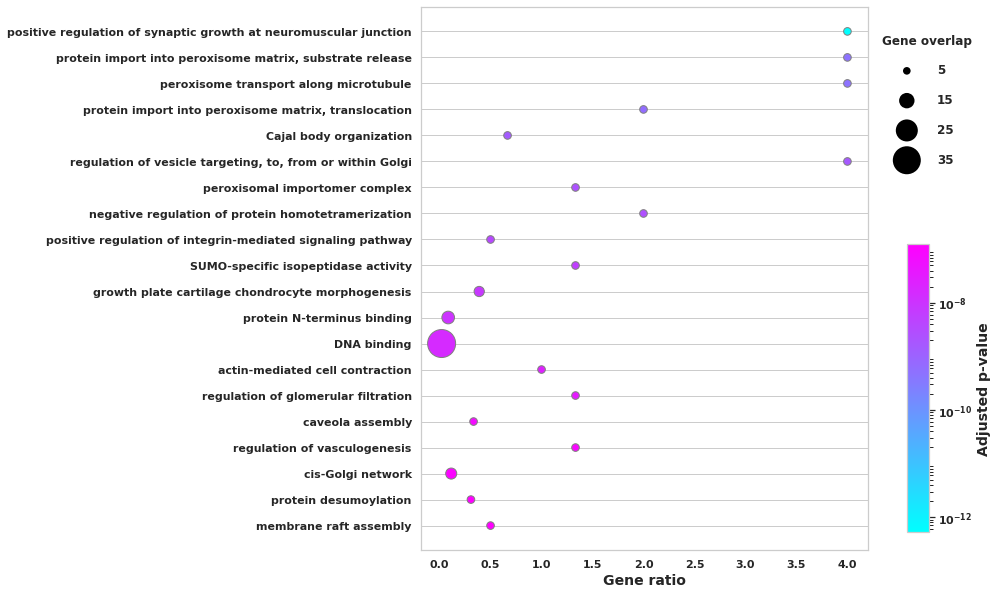

In [7]:
plot = enrichment.rename(columns={"binom_p_value" : "p_value", "go_term":"name"})
plt.figure(figsize=(10,10))
great.pl.plot_enrich(plot)

In [22]:
from math import exp, fabs, lgamma, log

import dask.dataframe as dd
import numpy as np
import pandas as pd
from scipy.special import comb
from statsmodels.stats.multitest import multipletests
import bindome as bd 
pd.options.display.float_format = "{:12.5e}".format


class GREAT:
    def loader(
        test_data: None or str or pd.DataFrame,
        regdom_file: None or str or pd.DataFrame,
        chr_size_file: None or str or pd.DataFrame,
        annotation_file: None or str or pd.DataFrame,
    ):
        """
        Used to load all datasets needed for the enrichment calculation

        Parameters
        ----------
        test_data : None or str or pd.DataFrame
            Genomic set of peaks to be tested
        regdom_file : None or str or pd.DataFrame
            Regulatory domain of all genes in the genome
        chr_size_file : None or str or pd.DataFrame
            Table with the size of each chromosome
        annotation_file : None or str or pd.DataFrame
            Table with the annotation of each gene in the genome

        Returns
        -------
        test_data : pd.DataFrame
            Genomic set of peaks to be tested in the good format
        regdom : pd.DataFrame
            Regulatory domain of all genes in the genome in the good format
        size : pd.DataFrame
            Table with the size of each chromosome in the good format
        ann : pd.DataFrame
            Table with the annotation of each gene in the genome in the good format

        Examples
        --------
        >>> test,regdom,size,ann = GREAT.loader(
            "../../data/tests/test_data/input/02_srf_hg38.bed",
            "../../data/human/hg38/regulatory_domain.bed",
            "../../data/human/hg38/chr_size.bed",
            "../data/human/ontologies.csv"
            )

        >>> test.head()
        ...    |    | Chr   |   Chr_Start |   Chr_End |
        ...    |---:|:------|------------:|----------:|
        ...    |  0 | chr1  |     1052028 |   1052049 |
        ...    |  1 | chr1  |     1065512 |   1065533 |
        ...    |  2 | chr1  |     1067375 |   1067397 |
        ...    |  3 | chr1  |     1068083 |   1068119 |
        ...    |  4 | chr1  |    10520283 |  10520490 |

        >>> regdom.head()
        ...    |    | Chr   |   Chr_Start |   Chr_End | Name      |   tss | Strand   |
        ...    |---:|:------|------------:|----------:|:----------|------:|:---------|
        ...    |  0 | chr1  |           0 |     22436 | MIR6859-1 | 17436 | -        |
        ...    |  1 | chr1  |       16436 |     22436 | MIR6859-2 | 17436 | -        |
        ...    |  2 | chr1  |       16436 |     22436 | MIR6859-3 | 17436 | -        |
        ...    |  3 | chr1  |       16436 |     28370 | MIR6859-4 | 17436 | -        |
        ...    |  4 | chr1  |       22436 |     34370 | WASH7P    | 29370 | -        |

        >>> size.head()
        ...    |    | Chrom   |      Size |
        ...    |---:|:--------|----------:|
        ...    |  0 | chr1    | 248956422 |
        ...    |  1 | chr2    | 242193529 |
        ...    |  2 | chr3    | 198295559 |
        ...    |  3 | chr4    | 190214555 |
        ...    |  4 | chr5    | 181538259 |

        >>> ann.head()
        ...    |    | id         | name                                                   | symbol        |
        ...    |---:|:-----------|:-------------------------------------------------------|:--------------|
        ...    |  0 | GO:0003924 | GTPase activity                                        | DNAJC25-GNG10 |
        ...    |  1 | GO:0007186 | G protein-coupled receptor signaling pathway           | DNAJC25-GNG10 |
        ...    |  2 | GO:0003723 | RNA binding                                            | NUDT4B        |
        ...    |  3 | GO:0005829 | cytosol                                                | NUDT4B        |
        ...    |  4 | GO:0008486 | diphosphoinositol-polyphosphate diphosphatase activity | NUDT4B        |

        """

        if type(regdom_file) == str:
            regdom = pd.read_csv(
                regdom_file,
                sep="\t",
                comment="#",
                names=["chr", "chr_start", "chr_end", "Name", "tss", "Strand"],
                dtype={
                    "chr": "object",
                    "chr_start": "int64",
                    "chr_end": "int64",
                    "Name": "object",
                    "tss": "int64",
                    "Strand": "object",
                },
            )
        elif type(regdom_file) == pd.DataFrame:
            regdom = regdom_file.iloc[:, :6]
            colname = list(regdom.columns)
            try:
                regdom = regdom.rename(
                    columns={
                        colname[0]: "chr",
                        colname[1]: "chr_start",
                        colname[2]: "chr_end",
                        colname[3]: "Name",
                        colname[4]: "tss",
                        colname[5]: "Strand",
                    }
                )
            except:
                print("Error in the format of the regdom file")
                print("The regdom file must have the following columns : Chr, Chr_Start, Chr_End, Name, tss, Strand")
                return False
        else:
            regdom = regdom_file

        if type(test_data) == str:
            test_data = pd.read_csv(
                test_data,
                sep="\t",
                comment="#",
                usecols=[0, 1, 2],
                names=["chr", "chr_start", "chr_end"],
                dtype={"chr": "object", "chr_start": "int64", "chr_end": "int64"},
            )
        elif type(test_data) == pd.DataFrame:
            test_data = test_data.iloc[:, :3]
            colname = list(test_data.columns)
            try:
                test_data = test_data.rename(
                    columns={colname[0]: "chr", colname[1]: "chr_start", colname[2]: "chr_end"}
                )
            except:
                print("Error in test dataframe, please check your input")
                print("Columns should be : chr...(type object), start(type int), end(type int)")
                return False
        else:
            pass

        if type(chr_size_file) == str:
            size = pd.read_csv(
                chr_size_file,
                sep="\t",
                comment="#",
                names=["Chrom", "Size"],
                dtype={"Chrom": "object", "Size": "int64"},
            )
        elif type(chr_size_file) == pd.DataFrame:
            size = chr_size_file.iloc[:, :2]
            colname = list(size.columns)
            try:
                size = size.rename(columns={colname[0]: "Chrom", colname[1]: "Size"})
            except:
                print("Error in the format of the chr_size file")
                print("The chr_size file must have the following columns : Chrom, Size")
                return False
        else:
            size = chr_size_file

        if type(annotation_file) == str:
            dask_df = dd.read_csv(
                annotation_file,
                sep=";",
                comment="#",
                dtype={
                    "ensembl": "object",
                    "id": "object",
                    "name": "object",
                    "ontology.group": "object",
                    "gene.name": "object",
                    "symbol": "object",
                },
                usecols=["id", "name", "symbol"],
                low_memory=False,
            )
            ann = dask_df.compute()
            ann = ann[ann["id"].str.match("^GO.*") == True]
        elif type(annotation_file) == pd.DataFrame:
            ann = annotation_file.iloc[:, :4]
            colname = list(ann.columns)
            try:
                ann = ann.rename(columns={colname[0]: "id", colname[1]: "name", colname[3]: "symbol"})
            except:
                print("Error in the format of the annotation file")
                print("The annotation file must have the following columns : id, name, symbol")
                return False
        else:
            ann = annotation_file

        return test_data, regdom, size, ann

    def __enrichment_binom_and_hypergeom(
        test: pd.DataFrame, regdom: pd.DataFrame, size: pd.DataFrame, ann: pd.DataFrame, asso: list
    ) -> pd.DataFrame:
        """
        Used to compute the enrichment of the test data using the binomial test and the hypergeometric test.

        Parameters
        ----------
        test : pd.DataFrame
            Genomic set of peaks to be tested
        regdom : pd.DataFrame
            Regulatory domain of all genes in the genome
        chr_size :  pd.DataFrame
            Table with the size of each chromosome
        annotation : pd.DataFrame
            Table with the annotation of each gene in the genome
        asso : list
            List of the association between gene from regdom and peaks from test

        Returns
        -------
        pd.DataFrame
            dataframe contains for every GO ID associate with a every associated gene the p-value for the binomial test and the the hypergeometric test

        Examples
        --------
        >>> test,regdom,size,ann = GREAT.loader(
            "../../data/tests/test_data/input/02_srf_hg38.bed",
            "../../data/human/hg38/regulatory_domain.bed",
            "../../data/human/hg38/chr_size.bed",
            "../data/human/ontologies.csv"
            )
        >>> enrichment = GREAT.____enrichment_binom_and_hypergeom(
            test = test,
            regdom = regdom,
            size = size,
            ann = ann,
            asso = get_association(test,regdom)
            )

        >>> enrichment.head()
        ...    |            | go_term                                                          |   binom_p_value |   hypergeom_p_value |
        ...    |:-----------|:-----------------------------------------------------------------|----------------:|--------------------:|
        ...    | GO:0045887 | positive regulation of synaptic growth at neuromuscular junction |     5.17744e-13 |          0.0029275  |
        ...    | GO:0044721 | protein import into peroxisome matrix, substrate release         |     4.83812e-10 |          0.0029275  |
        ...    | GO:0036250 | peroxisome transport along microtubule                           |     4.83812e-10 |          0.0029275  |
        ...    | GO:0016561 | protein import into peroxisome matrix, translocation             |     6.31131e-10 |          0.00584656 |
        ...    | GO:0047485 | protein N-terminus binding                                       |     1.2945e-09  |          0.0050377  |
        """
        # Init Great
        res = {}
        hit = {}

        # init Hypergeom
        hypergeom_gene_set = len(asso)  # get the number of genes in the test gene set.
        hypergeom_total_number_gene = regdom.shape[0]  # get the number of genes in the genome.

        # Init binom
        n_binom = test.shape[0]  # get the number of genomic region in the test set
        total_nu = size["Size"].sum()  # get the total number of nucleotides in the genome

        ann_red = ann[ann["symbol"].isin(asso)]
        regdom = regdom[
            regdom["Name"].isin(list(ann[ann["id"].isin(list(ann_red["id"]))]["symbol"]))
        ]  # reduction of the regdom file by selecting only the genes whose GO ID is owned by a gene of the association
        len_on_chr = len_regdom(regdom)  # get the length of each regulatory domain

        # Compute for all associating gene and for each GO id associated with the gene the probability.
        for name in asso:
            ann_name_gene = ann[ann["symbol"].isin([name])]
            id = ann_name_gene["id"]
            ann_reduce = ann[ann["id"].isin(list(id))]
            tmp = []
            for i in list(id.unique()):
                gene_imply = ann_reduce[ann_reduce["id"].isin([i])]
                K_hypergeom = gene_imply.shape[0]  # get be the number of genes in the genome with annotation
                curr_regdom = regdom.loc[regdom["Name"].isin(list(gene_imply["symbol"]))]
                k_hypergeom = curr_regdom.loc[curr_regdom["Name"].isin(asso)].shape[
                    0
                ]  # get the number of genes in the test gene set with annotation

                if i not in list(hit.keys()):
                    hit[i] = number_of_hits(
                        test, curr_regdom
                    )  # get the number of test genomic regions in the regulatory domain of a gene with annotation
                k_binom = hit[i]
                nb_binom = sum(
                    len_on_chr[i] for i in curr_regdom["Name"]
                )  # get the portion of the genome in the regulatory domain of a gene with annotation
                tmp.append((k_binom, nb_binom, i, gene_imply.iloc[0]["name"], K_hypergeom, k_hypergeom))

            res.update(
                {
                    elem[2]: [
                        elem[3],
                        get_binom_pval(n_binom, elem[0], elem[1] / total_nu),
                        elem[0] / (elem[1] / total_nu),  # binom enrichment
                        hypergeom_cdf(hypergeom_total_number_gene, elem[4], hypergeom_gene_set, elem[5]),
                        (elem[5] * hypergeom_total_number_gene)
                        / (hypergeom_gene_set * elem[4]),  # Hypergeom enrichment
                        elem[0],
                        elem[0] / elem[4],
                    ]
                    for elem in tmp
                }
            )

        return (
            pd.DataFrame(res)
            .transpose()
            .rename(
                columns={
                    0: "go_term",
                    1: "binom_p_value",
                    2: "binom_fold_enrichment",
                    3: "hypergeom_p_value",
                    4: "hypergeometric_fold_enrichment",
                    5: "intersection_size",
                    6: "recall",
                }
            )
            .replace(0, np.nan)
            .dropna()
            .sort_values(by="binom_p_value")
        )

    def __enrichment_binom(
        test: pd.DataFrame, regdom: pd.DataFrame, size: pd.DataFrame, ann: pd.DataFrame, asso: list
    ) -> pd.DataFrame:
        """
        Used to compute the enrichment of the test data using the binomial test.

        Parameters
        ----------
        test : pd.DataFrame
            Genomic set of peaks to be tested
        regdom : pd.DataFrame
            Regulatory domain of all genes in the genome
        chr_size :  pd.DataFrame
            Table with the size of each chromosome
        annotation : pd.DataFrame
            Table with the annotation of each gene in the genome
        asso : list
            List of the association between gene from regdom and peaks from test

        Returns
        -------
        pd.DataFrame
            dataframe contains for every GO ID associate with a every associated gene the p-value for the binomial test

        Examples
        --------
        >>> test,regdom,size,ann = GREAT.loader(
            "../../data/tests/test_data/input/02_srf_hg38.bed",
            "../../data/human/hg38/regulatory_domain.bed",
            "../../data/human/hg38/chr_size.bed",
            "../data/human/ontologies.csv"
            )
        >>> enrichment = GREAT.____enrichment_binom(
            test = test,
            regdom = regdom,
            size = size,
            ann = ann,
            asso = get_association(test,regdom)
            )
        >>> enrichment.head()
        ...    |            | go_term                                                   |   binom_p_value |   binom_fold_enrichment |   intersection_size |   recall |
        ...    |:-----------|:----------------------------------------------------------|----------------:|------------------------:|--------------------:|---------:|
        ...    | GO:0072749 | cellular response to cytochalasin B                       |     2.21968e-12 |                227251   |                   5 |  5       |
        ...    | GO:0051623 | positive regulation of norepinephrine uptake              |     2.21968e-12 |                227251   |                   5 |  5       |
        ...    | GO:0098973 | structural constituent of postsynaptic actin cytoskeleton |     2.1174e-10  |                 91052.6 |                   5 |  1.25    |
        ...    | GO:0097433 | dense body                                                |     6.40085e-10 |                 16061.8 |                   8 |  1.33333 |
        ...    | GO:0032796 | uropod organization                                       |     2.6988e-09  |                 54544.9 |                   5 |  2.5     |
        """
        # Init Great
        res = {}
        hit = {}

        # Init binom
        n_binom = test.shape[0]  # get the number of genomic region in the test set
        total_nu = size["Size"].sum()  # get the total number of nucleotides in the genome

        ann_red = ann[ann["symbol"].isin(asso)]
        regdom = regdom[
            regdom["Name"].isin(list(ann[ann["id"].isin(list(ann_red["id"]))]["symbol"]))
        ]  # reduction of the regdom file by selecting only the genes whose GO ID is owned by a gene of the association
        len_on_chr = len_regdom(regdom)  # get the length of each regulatory domain

        # Compute for all associating gene and for each GO id associated with the gene the probability.
        for name in asso:
            ann_name_gene = ann[ann["symbol"].isin([name])]
            id = ann_name_gene["id"]
            ann_reduce = ann[ann["id"].isin(list(id))]
            tmp = []
            for i in list(id.unique()):
                gene_imply = ann_reduce[ann_reduce["id"].isin([i])]
                K = gene_imply.shape[0]
                curr_regdom = regdom.loc[regdom["Name"].isin(list(gene_imply["symbol"]))]

                if i not in list(hit.keys()):
                    hit[i] = number_of_hits(
                        test, curr_regdom
                    )  # get the number of test genomic regions in the regulatory domain of a gene with annotation
                k_binom = hit[i]
                nb_binom = sum(
                    len_on_chr[i] for i in curr_regdom["Name"]
                )  # get the portion of the genome in the regulatory domain of a gene with annotation
                tmp.append(k_binom, nb_binom, i, gene_imply.iloc[0]["name"], K)

            res.update(
                {
                    elem[2]: [
                        elem[3],
                        get_binom_pval(n_binom, elem[0], elem[1] / total_nu),
                        elem[0] / (elem[1] / total_nu),  # binom enrichment
                        elem[0],
                        elem[0] / elem[4],
                    ]
                    for elem in tmp
                }
            )

        return (
            pd.DataFrame(res)
            .transpose()
            .rename(
                columns={
                    0: "go_term",
                    1: "binom_p_value",
                    2: "binom_fold_enrichment",
                    3: "intersection_size",
                    4: "recall",
                }
            )
            .sort_values(by="binom_p_value")
        )

    def __enrichment_hypergeom(test: pd.DataFrame, regdom: pd.DataFrame, ann: pd.DataFrame, asso: list) -> pd.DataFrame:
        """
        Used to compute the enrichment of the test data using the hypergeometric test.

        Parameters
        ----------
        test : pd.DataFrame
            Genomic set of peaks to be tested
        regdom : pd.DataFrame
            Regulatory domain of all genes in the genome
        chr_size :  pd.DataFrame
            Table with the size of each chromosome
        annotation : pd.DataFrame
            Table with the annotation of each gene in the genome
        asso : list
            List of the association between gene from regdom and peaks from test

        Returns
        -------
        pd.DataFrame
            dataframe contains for every GO ID associate with a every associated gene the p-value for the hypergeometric test

        Examples
        --------
        >>> test,regdom,size,ann = GREAT.loader(
            "../data/tests/test_data/input/03_srf_hg19.bed",
            "../data/human/hg19/regulatory_domain.bed",
            "../data/human/hg19/chr_size.bed",
            "../data/human/ontologies.csv"
            )
        >>> enrichment = GREAT.____enrichment_hypergeom(
            test = test,
            regdom = regdom,
            ann = ann,
            asso = get_association(test,regdom)
            )
        >>> enrichment.head()
        ...    |            | go_term                                                                                    |   hypergeom_p_value |   hypergeometric_fold_enrichment |   intersection_size |    recall |
        ...    |:-----------|:-------------------------------------------------------------------------------------------|--------------------:|---------------------------------:|--------------------:|----------:|
        ...    | GO:0015629 | actin cytoskeleton                                                                         |         2.25347e-06 |                          2.73071 |                  27 | 0.116883  |
        ...    | GO:1903979 | negative regulation of microglial cell activation                                          |         0.000302551 |                         17.522   |                   3 | 0.75      |
        ...    | GO:1902626 | assembly of large subunit precursor of preribosome                                         |         0.000302551 |                         17.522   |                   3 | 0.75      |
        ...    | GO:0001077 | proximal promoter DNA-binding transcription activator activity, RNA polymerase II-specific |         0.000504006 |                          1.94689 |                  29 | 0.0833333 |
        ...    | GO:0000977 | RNA polymerase II regulatory region sequence-specific DNA binding                          |         0.000511704 |                          2.03154 |                  26 | 0.0869565 |
        """
        # Init Great
        res = {}

        # Init hypergeom
        hypergeom_total_number_gene = regdom.shape[0]  # get the number of genes in the genome
        hypergeom_gene_set = len(asso)  # get the number of genes in the test gene set.

        ann_red = ann[ann["symbol"].isin(asso)]
        regdom = regdom[
            regdom["Name"].isin(list(ann[ann["id"].isin(list(ann_red["id"]))]["symbol"]))
        ]  # reduction of the regdom file by selecting only the genes whose GO ID is owned by a gene of the association

        # Compute for all associating gene and for each GO id associated with the gene the probability.
        for name in asso:
            ann_name_gene = ann[ann["symbol"] == name]
            id = ann_name_gene["id"]
            ann_reduce = ann[ann["id"].isin(list(id))]
            tmp = []
            for i in list(id.unique()):
                gene_imply = ann_reduce[ann_reduce["id"] == i]
                K_hypergeom = gene_imply.shape[0]  # get be the number of genes in the genome with annotation
                curr_regdom = regdom.loc[regdom["Name"].isin(list(gene_imply["symbol"]))]
                k_hypergeom = curr_regdom.loc[curr_regdom["Name"].isin(asso)].shape[
                    0
                ]  # get the number of genes in the test gene set with annotation
                tmp.append((i, gene_imply.iloc[0]["name"], K_hypergeom, k_hypergeom))

            res.update(
                {
                    elem[0]: [
                        elem[1],
                        hypergeom_cdf(hypergeom_total_number_gene, elem[2], hypergeom_gene_set, elem[3]),
                        (elem[3] * hypergeom_total_number_gene)
                        / (hypergeom_gene_set * elem[2]),  # hypergeom enrichment
                        elem[3],
                        elem[3] / elem[2],
                    ]
                    for elem in tmp
                }
            )

        return (
            pd.DataFrame(res)
            .transpose()
            .rename(
                columns={
                    0: "go_term",
                    1: "hypergeom_p_value",
                    2: "hypergeometric_fold_enrichment",
                    3: "intersection_size",
                    4: "recall",
                }
            )
            .replace(0, np.nan)
            .dropna()
            .sort_values(by="hypergeom_p_value")
        )

    def enrichment(
        test_file: str or pd.DataFrame,
        regdom_file: str or pd.DataFrame,
        chr_size_file: str or pd.DataFrame,
        annotation_file: str or pd.DataFrame,
        binom=True,
        hypergeom=True,
    ) -> pd.DataFrame:
        """
        Wrapper of the 3 private methods:
        * GREAT.__enrichment_binom_and_hypergeom
        * GREAT.__enrichment_binom
        * GREAT.__enrichment_hypergeom

        Parameters
        ----------
        test_file : str or pd.DataFrame
            Genomic set of peaks to be tested
        regdom_file : str or pd.DataFrame
            Regulatory domain of all genes in the genome
        chr_size_file : str or pd.DataFrame
            Table with the size of each chromosome
        annotation_file : str or pd.DataFrame
            Table with the annotation of each gene in the genome
        binom : bool (default True)
            If True, the binomial test is used.
        hypergeom : bool (default True)
            If True, the hypergeometric test is used.

        Returns
        -------
        pd.DataFrame
            dataframe contains for every GO ID associate with a every associated gene the p-value for the hypergeometric test

        Examples
        --------
        >>> test,regdom,size,ann = GREAT.loader(
            "../data/tests/test_data/input/03_srf_hg19.bed",
            "../data/human/hg19/regulatory_domain.bed",
            "../data/human/hg19/chr_size.bed",
            "../data/human/ontologies.csv"
            )
        >>> enrichment = GREAT.enrichment(
            test = test,
            regdom = regdom,
            chr_size_file = size,
            ann = ann,
            binom=True,
            hypergeom=True
            )
        >>> enrichment.head()
        ...    |            | go_term                                                   |   binom_p_value |   binom_fold_enrichment |   hypergeom_p_value |   hypergeometric_fold_enrichment |   intersection_size |   recall |
        ...    |:-----------|:----------------------------------------------------------|----------------:|------------------------:|--------------------:|---------------------------------:|--------------------:|---------:|
        ...    | GO:0072749 | cellular response to cytochalasin B                       |     2.21968e-12 |                227251   |          0.0428032  |                         23.3627  |                   5 |  5       |
        ...    | GO:0051623 | positive regulation of norepinephrine uptake              |     2.21968e-12 |                227251   |          0.0428032  |                         23.3627  |                   5 |  5       |
        ...    | GO:0098973 | structural constituent of postsynaptic actin cytoskeleton |     2.1174e-10  |                 91052.6 |          0.160543   |                          5.84068 |                   5 |  1.25    |
        ...    | GO:0097433 | dense body                                                |     6.40085e-10 |                 16061.8 |          0.00141783 |                         11.6814  |                   8 |  1.33333 |
        ...    | GO:0032796 | uropod organization                                       |     2.6988e-09  |                 54544.9 |          0.00182991 |                         23.3627  |                   5 |  2.5     |

        >>> enrichment = GREAT.enrichment(
            test = test,
            regdom = regdom,
            ann = ann,
            asso = get_association(test,regdom),
            binom=True,
            hypergeom=False
            )
        ...    |            | go_term                                                   |   binom_p_value |   binom_fold_enrichment |   intersection_size |   recall |
        ...    |:-----------|:----------------------------------------------------------|----------------:|------------------------:|--------------------:|---------:|
        ...    | GO:0072749 | cellular response to cytochalasin B                       |     2.21968e-12 |                227251   |                   5 |  5       |
        ...    | GO:0051623 | positive regulation of norepinephrine uptake              |     2.21968e-12 |                227251   |                   5 |  5       |
        ...    | GO:0098973 | structural constituent of postsynaptic actin cytoskeleton |     2.1174e-10  |                 91052.6 |                   5 |  1.25    |
        ...    | GO:0097433 | dense body                                                |     6.40085e-10 |                 16061.8 |                   8 |  1.33333 |
        ...    | GO:0032796 | uropod organization                                       |     2.6988e-09  |                 54544.9 |                   5 |  2.5     |

        >>> enrichment = GREAT.enrichment(
            test = test,
            regdom = regdom,
            ann = ann,
            asso = get_association(test,regdom),
            binom=False,
            hypergeom=True
            )
        >>> enrichment.head()
        ...    |            | go_term                                                                                    |   hypergeom_p_value |   hypergeometric_fold_enrichment |   intersection_size |    recall |
        ...    |:-----------|:-------------------------------------------------------------------------------------------|--------------------:|---------------------------------:|--------------------:|----------:|
        ...    | GO:0015629 | actin cytoskeleton                                                                         |         2.25347e-06 |                          2.73071 |                  27 | 0.116883  |
        ...    | GO:1903979 | negative regulation of microglial cell activation                                          |         0.000302551 |                         17.522   |                   3 | 0.75      |
        ...    | GO:1902626 | assembly of large subunit precursor of preribosome                                         |         0.000302551 |                         17.522   |                   3 | 0.75      |
        ...    | GO:0001077 | proximal promoter DNA-binding transcription activator activity, RNA polymerase II-specific |         0.000504006 |                          1.94689 |                  29 | 0.0833333 |
        ...    | GO:0000977 | RNA polymerase II regulatory region sequence-specific DNA binding                          |         0.000511704 |                          2.03154 |                  26 | 0.0869565 |

        """
        if not binom and not hypergeom:
            return False

        test, regdom, size, ann = GREAT.loader(test_file, regdom_file, chr_size_file, annotation_file)
        asso = get_association(
            test, regdom
        )  # get the name of the regulatory domain associated to each genomic region in the test set

        if binom and hypergeom:
            return GREAT.__enrichment_binom_and_hypergeom(test, regdom, size, ann, asso)

        elif binom:
            return GREAT.__enrichment_binom(test, regdom, size, ann, asso)

        else:
            return GREAT.__enrichment_hypergeom(test, regdom, ann, asso)
    
    def enrichment_multiple(
        tests: list ,
        regdom_file: str or pd.DataFrame,
        chr_size_file: str or pd.DataFrame,
        annotation_file: str or pd.DataFrame,
        annpath: str = "../../annotation/",
        binom=True,
        hypergeom=True,
        ) -> dict:
        """
        Compute the enrichment of each GO term on multiple tests sets using bindome. 

        Parameters
        ----------
        tests : list
            List of complete name of data to compute with bindome
        regdom_file : str or pd.DataFrame
            Regulatory domain of all genes in the genome
        chr_size_file : str or pd.DataFrame
            Table with the size of each chromosome
        annotation_file : str or pd.DataFrame
            Table with the annotation of each gene in the genome
        binom : bool (default True)
            If True, the binomial test is used.
        hypergeom : bool (default True)
            If True, the hypergeometric test is used.

        Returns
        -------
        list of pd.DataFrame
            List of dataframe with the enrichment of each test

        Examples
        --------
        >>> tests = ["MAX:K-562,WA01,HeLa-S3", "BACH1:A-549,GM12878"]
        """
        if not binom and not hypergeom:
            return False
        
        _, regdom, size, ann = GREAT.loader(None, regdom_file, chr_size_file, annotation_file)
        
        bd.bindome.constants.ANNOTATIONS_DIRECTORY = annpath

        res = {}
        
        for name in tests : 
            name_TF = name.split(":")[0]
            tmp_df = bd.bindome.datasets.REMAP2020.get_remap_peaks(name_TF)
            
            tmp = tmp_df[tmp_df[3]==name].iloc[:,0:3]
            return tmp
            tmp = tmp.rename(columns={"chr":'Chr','start':"Chr_start",'end':"Chr_end"})

            enrichment = GREAT.enrichment(
                test = tmp,
                regdom = regdom,
                ann = ann,
                chr_size_file=size,
                asso = get_association(tmp,regdom),
                binom=binom,
                hypergeom=hypergeom
            )
            
            res[name_TF] = enrichment

        return res

    def set_bonferroni(self, alpha: float = 0.05) -> pd.DataFrame:
        """
        Create new columns in the dataframe with the Bonferroni correction

        Parameters
        ----------
        alpha : float
            alpha value for the Bonferroni correction

        Returns
        -------
        pd.DataFrame
            dataframe new columns with the Bonferroni correction for each p-value

        Examples
        --------
        >>> test,regdom,size,ann = GREAT.loader(
            "../data/tests/test_data/input/03_srf_hg19.bed",
            "../data/human/hg19/regulatory_domain.bed",
            "../data/human/hg19/chr_size.bed",
            "../data/human/ontologies.csv"
            )
        >>> enrichment = great.tl.GREAT.enrichment(
            "../data/tests/test_data/input/03_srf_hg19.bed",
            "../data/human/hg19/regulatory_domain.bed",
            "../data/human/hg19/chr_size.bed",
            "../data/human/ontologies.csv",
            binom=True,
            hypergeom=True
            )
        >>> bonferroni = GREAT.set_bonferroni(enrichment,alpha=0.05)
        >>> bonferroni.head()
        ...    |            | go_term                                                          |   binom_p_value |   hypergeom_p_value |   binom_bonferroni |   hypergeom_bonferroni |
        ...    |:-----------|:-----------------------------------------------------------------|----------------:|--------------------:|-------------------:|-----------------------:|
        ...    | GO:0045887 | positive regulation of synaptic growth at neuromuscular junction |     5.17744e-13 |          0.0029275  |        3.0754e-10  |                      1 |
        ...    | GO:0044721 | protein import into peroxisome matrix, substrate release         |     4.83812e-10 |          0.0029275  |        2.87384e-07 |                      1 |
        ...    | GO:0036250 | peroxisome transport along microtubule                           |     4.83812e-10 |          0.0029275  |        2.87384e-07 |                      1 |
        ...    | GO:0016561 | protein import into peroxisome matrix, translocation             |     6.31131e-10 |          0.00584656 |        3.74892e-07 |                      1 |
        ...    | GO:0047485 | protein N-terminus binding                                       |     1.2945e-09  |          0.0050377  |        7.68931e-07 |                      1 |

        """
        for col in self.columns:
            if col in ["binom_p_value", "hypergeom_p_value"]:
                col_split = col.split("_")
                self[f"{col_split[0]}_bonferroni"] = multipletests(self[col], alpha=alpha, method="bonferroni")[1]
        return self

    def set_fdr(self, alpha: float = 0.05) -> pd.DataFrame:
        """
        Create new columns in the dataframe with the fdr correction

        Parameters
        ----------
        alpha : float
            alpha value for the fdr correction

        Returns
        -------
        pd.DataFrame
            dataframe new columns with the fdr correction for each p-value

        Examples
        --------
        >>> test,regdom,size,ann = GREAT.loader(
            "../data/tests/test_data/input/03_srf_hg19.bed",
            "../data/human/hg19/regulatory_domain.bed",
            "../data/human/hg19/chr_size.bed",
            "../data/human/ontologies.csv"
            )
        >>> enrichment = great.tl.GREAT.enrichment(
            "../data/tests/test_data/input/03_srf_hg19.bed",
            "../data/human/hg19/regulatory_domain.bed",
            "../data/human/hg19/chr_size.bed",
            "../data/human/ontologies.csv",
            binom=True,
            hypergeom=True
            )
        >>> fdr = GREAT.set_fdr(enrichment,alpha=0.05)
        >>> fdr.head()
        ...    |            | go_term                                                          |   binom_p_value |   hypergeom_p_value |   binom_fdr |   hypergeom_fdr |
        ...    |:-----------|:-----------------------------------------------------------------|----------------:|--------------------:|------------:|----------------:|
        ...    | GO:0045887 | positive regulation of synaptic growth at neuromuscular junction |     5.17744e-13 |          0.0029275  | 3.0754e-10  |       0.0913909 |
        ...    | GO:0044721 | protein import into peroxisome matrix, substrate release         |     4.83812e-10 |          0.0029275  | 9.3723e-08  |       0.0913909 |
        ...    | GO:0036250 | peroxisome transport along microtubule                           |     4.83812e-10 |          0.0029275  | 9.3723e-08  |       0.0913909 |
        ...    | GO:0016561 | protein import into peroxisome matrix, translocation             |     6.31131e-10 |          0.00584656 | 9.3723e-08  |       0.0913909 |
        ...    | GO:0047485 | protein N-terminus binding                                       |     1.2945e-09  |          0.0050377  | 1.53786e-07 |       0.0913909 |

        """
        for col in self.columns:
            if col in ["binom_p_value", "hypergeom_p_value"]:
                col_split = col.split("_")
                self[f"{col_split[0]}_fdr"] = multipletests(self[col], alpha=alpha, method="fdr_bh")[1]
        return self

    def set_threshold(self, colname: str, alpha: int = 0.05) -> pd.DataFrame:
        """
        Delete rows according to the p-value of the column taken as argument. By default the alpha value is 0.05

        Parameters
        ----------
        alpha : float
            alpha value for the fdr correction

        Returns
        -------
        pd.DataFrame
            dataframe with the rows deleted according to the p-value threshold

        Examples
        --------
        >>> test,regdom,size,ann = GREAT.loader(
            "../data/tests/test_data/input/03_srf_hg19.bed",
            "../data/human/hg19/regulatory_domain.bed",
            "../data/human/hg19/chr_size.bed",
            "../data/human/ontologies.csv"
            )
        >>> enrichment = great.tl.GREAT.enrichment(
            "../data/tests/test_data/input/03_srf_hg19.bed",
            "../data/human/hg19/regulatory_domain.bed",
            "../data/human/hg19/chr_size.bed",
            "../data/human/ontologies.csv",
            binom=True,
            hypergeom=True
            )
        >>> enrichment.shape[0]
        ...    594

        >>> significant = GREAT.set_threshold(enrichment,colname="binom_p_value",alpha=0.05)
        >>> significant.shape[0]
        ...    310

        """
        if colname in self.columns:
            self = self.loc[self[colname] <= alpha]
        return self


######################################################################
################# Utils function used by GREAT class #################
######################################################################
def get_association(test, regdom) -> list:
    """
    From a file of genomic regions from CHIPseq
    and a file of genomic regulatory domains determine the names
    of genes associated with at least one genomic region

    Parameters
    ----------
    test : pd.dataFrame
        df of the tests pics => columns: ["chr","chr_start","chr_end"]

    regdom : pd.dataFrame
        df of the regulatory domains => columns: ["chr"	"chr_start"	"chr_end"	"Name"	"tss"	"strand"].

    Returns
    -------
    res : list
        list of gene associated with at least with one test peak

    Examples
    --------
    >>> test = pd.DataFrame(
        {
            "chr":["chr1"],
            "chr_start":[1052028],
            "chr_end": [1052049]}
        )
    >>> regdom = pd.DataFrame(
        {
            "chr":["chr1","chr1"],
            "chr_start":[1034992,1079306],
            "chr_end": [1115089,1132016],
            "Name":["RNF223","C1orf159"],
            "tss":[1074306,1116089],
            "strand":['-','-']
        })
    >>> get_association(test,regdom)
    ...    ['RNF223']

    """
    res = []
    for i in range(test.shape[0]):
        currTest = test.iloc[i]
        regdom_curr_test = regdom.loc[(regdom["chr"] == currTest["chr"])].sort_values("chr_start")
        regdom_curr_test = regdom_curr_test.loc[
            (
                (regdom_curr_test["chr_start"] <= currTest["chr_start"])
                & (regdom_curr_test["chr_end"] >= currTest["chr_end"])
            )
            | (  # regdom overlap totally test
                (regdom_curr_test["chr_start"] >= currTest["chr_start"])
                & (regdom_curr_test["chr_end"] <= currTest["chr_end"])
            )
            | (  # test overlap totally regdom
                (regdom_curr_test["chr_start"] <= currTest["chr_start"])
                & (regdom_curr_test["chr_end"] <= currTest["chr_end"])
                & (regdom_curr_test["chr_end"] >= currTest["chr_start"])
            )
            | (  # regdom overlap not totally test on left side
                (regdom_curr_test["chr_start"] >= currTest["chr_start"])
                & (regdom_curr_test["chr_end"] >= currTest["chr_end"])
                & (regdom_curr_test["chr_start"] <= currTest["chr_end"])
            )  # regdom overlap not totally test on right side
        ]
        res = res + list(regdom_curr_test["Name"])
    return list(dict.fromkeys(res))


def len_regdom(regdom: pd.DataFrame) -> dict:
    """
    Calculate for each gene name from regdom the
    size of the regulatory region for this gene in the genome

    Parameters
    ----------
    regdom : pd.dataFrame
        df of the regulatory domains => columns: ["chr"	"chr_start"	"chr_end"	"Name"	"tss"	"strand"].

    Returns
    -------
    dict
        dictionary in which each key corresponds to a gene name
        from regdom and the value is the size of the regulatory
        region for that gene

    Examples
    --------
    >>> regdom = pd.DataFrame(
        {
            "chr":["chr1","chr1"],
            "chr_start":[1034992,1079306],
            "chr_end": [1115089,1132016],
            "Name":["RNF223","C1orf159"],
            "tss":[1074306,1116089],
            "strand":['-','-']
            })
    >>> len_regdom(regdom)
    ...    {'RNF223': 80097, 'C1orf159': 52710}

    """
    test = regdom["chr_end"] - regdom["chr_start"]
    return pd.DataFrame({"len": list(test)}, index=regdom["Name"]).to_dict()["len"]


def number_of_hits(test, regdom) -> int:
    """
    Calculate the number of hits from several
    genomic regions and the file describing the regulatory regions

    Parameters
    ----------
    test : pd.dataFrame
        df of the tests pics => columns: ["chr","chr_start","chr_end"]

    regdom : pd.dataFrame
        df of the regulatory domains => columns: ["chr"	"chr_start"	"chr_end"	"Name"	"tss"	"strand"].

    Returns
    -------
    nb : int
        number of hit

    Examples
    --------
    >>> test = pd.DataFrame(
        {
            "chr":["chr1"],
            "chr_start":[1052028],
            "chr_end": [1052049]}
        )
    >>> regdom = pd.DataFrame(
        {
            "chr":["chr1","chr1"],
            "chr_start":[1034992,1079306],
            "chr_end": [1115089,1132016],
            "Name":["RNF223","C1orf159"],
            "tss":[1074306,1116089],
            "strand":['-','-']
        })
    >>> number_of_hits(test,regdom)
    ...    1

    """
    nb = 0
    regdom = regdom[["chr", "chr_start", "chr_end"]]
    regdom = regdom[regdom["chr"].isin(list(test["chr"]))]
    for i in range(test.shape[0]):
        chrom = test.iat[i, 0]
        start = test.iat[i, 1]
        end = test.iat[i, 2]
        regdom_np = regdom["chr"].to_numpy()
        reg_start = regdom["chr_start"].to_numpy()
        reg_end = regdom["chr_end"].to_numpy()
        Chr_reduce = np.where(regdom_np == chrom)
        reg_start = np.take(reg_start, Chr_reduce, axis=0)[0]
        reg_end = np.take(reg_end, Chr_reduce, axis=0)[0]

        if any((reg_start <= start) & (reg_end >= end)):
            nb += 1
    return nb


def betacf(a, b, x):
    """Used by betai: Evaluates continued fraction for incomplete beta function"""
    maxit = 10000
    eps = 3.0e-7
    fpmin = 1.0e-30
    qab = a + b
    qap = a + 1
    qam = a - 1
    c = 1
    d = 1 - qab * x / qap
    if fabs(d) < fpmin:
        d = fpmin
    d = 1 / d
    h = d
    for m in range(1, maxit + 1):
        m2 = 2 * m
        aa = m * (b - m) * x / ((qam + m2) * (a + m2))
        d = 1.0 + aa * d
        if fabs(d) < fpmin:
            d = fpmin
        c = 1.0 + aa / c
        if fabs(c) < fpmin:
            c = fpmin
        d = 1.0 / d
        h *= d * c
        aa = -(a + m) * (qab + m) * x / ((a + m2) * (qap + m2))
        d = 1.0 + aa * d
        if fabs(d) < fpmin:
            d = fpmin
        c = 1.0 + aa / c
        if fabs(c) < fpmin:
            c = fpmin
        d = 1.0 / d
        dell = d * c
        h *= dell
        if fabs(dell - 1.0) < eps:
            break
    if m > maxit:
        print("a or b too big, or MAXIT too small in betacf")
        return False
    return h


def betai(a, b, x):
    """Returns the incomplete beta function Ix(a, b)."""
    if x < 0 or x > 1:
        # print("bad x in routine betai")
        return False
    if x == 0 or x == 1:
        bt = 0.0
    else:
        bt = exp(lgamma(a + b) - lgamma(a) - lgamma(b) + a * log(x) + b * log(1.0 - x))
    if x < (a + 1) / (a + b + 2):
        return bt * betacf(a, b, x) / a
    return 1 - bt * betacf(b, a, 1 - x) / b


def get_binom_pval(n: int, k: int, p: float) -> float:
    """
    Calculate the binomial probability
    of obtaining k in a set of size n and whose probability is p

    Parameters
    ----------
    n : int
        Number of genomic region in the test set
    k : int
        Number of test genomic regions in the regulatory domain of a gene with annotation
    p : float
        Percentage of genome annotated

    Returns
    -------
    float
        binomial probability

    Examples
    --------
    >>> get_binom_pval(100,2,0.2)
    ...    0.9999999947037065

    """
    if k == 0:
        return 1
    else:
        return betai(k, n - k + 1, p)


def hypergeom_pmf(N: int, K: int, n: int, k: int) -> float:
    """
    Calculate the probability mass function for hypergeometric distribution

    Parameters
    ----------
    N : int
        Total number of gene in the genome
    K : int
        Number of genes in the genome with annotation
    n : int
        Number of gene in the test set
    k : int
        Number of genes in the test gene set with annotation

    Returns
    -------
    float
        proability mass function

    Examples
    --------
    >>> hypergeom_pmf(100,10,30,1)
    ...    0.11270773995748315

    """
    Achoosex = comb(K, k, exact=True)
    NAchoosenx = comb(N - K, n - k, exact=True)
    Nchoosen = comb(N, n, exact=True)
    return ((Achoosex) * NAchoosenx) / Nchoosen


def hypergeom_cdf(N: int, K: int, n: int, k: int) -> float:
    """
    Calculate the cumulative density funtion for hypergeometric distribution

    Parameters
    ----------
    N : int
        Total number of gene in the genome
    K : int
        Number of genes in the genome with annotation
    n : int
        Number of gene in the test set
    k : int
        Number of genes in the test gene set with annotation

    Returns
    -------
    float
        Cumulative density function

    Examples
    --------
    >>> hypergeom_cdf(100,10,30,1)
    ...    0.9770827595419788

    """
    return np.sum([hypergeom_pmf(N, K, n, x) for x in range(k, min(K, n) + 1)])


In [23]:
tmp_df = GREAT.enrichment_multiple(
    tests = ["MAX:K-562,WA01,HeLa-S3", "BACH1:A-549,GM12878"], 
    regdom_file="../data/human/hg38/regulatory_domain.bed",
    chr_size_file="../data/human/hg38/chr_size.bed",
    annotation_file="../data/human/ontologies.csv",
    binom=True,
    hypergeom=True,
)

In [24]:
tmp_df

,chr,start,end
65,chr1,942529,942671
8460,chr1,24392414,24392552
26233,chr1,114525059,114525225
27034,chr1,117754168,117754345
27490,chr1,146036180,146036304
...,...,...,...
489940,chrX,49167092,49167580
490522,chrX,63350986,63351118
491606,chrX,78024792,78024982
492985,chrX,113929109,113929317


In [12]:
import matplotlib


test = [
    "SRF:Ishikawa,A-673-clone-Asp114,K-562,MCF-7,Hep-G2",
    "MAX:K-562,WA01,HeLa-S3", "BACH1:A-549,GM12878",
    "CDK9:A-375,MM1-S,MV4-11,P493-6,BT-474,HEK293T",
    "GATA1:erythroblast,HUDEP-2,K-562", "IKZF1:K-562,GM12878,HSPC", 
    "SP1:liver,A-375,Hep-G2,HEK293,GM12878,A-549,K-562,HEK293T,WA01",
    "TCF7:Hep-G2,GM12878,K-562", "ZBTB40:MCF-7,Hep-G2,GM12878",
    "AFF1:MV4-11,K-562"
    ]

def dotplot(test_data,annpath, n_row:int = 5,fig : matplotlib.figure.Figure or None = None,show_term_name : bool = True, term_name_nchars : int = 30): 
    """
    Dotplot of enrichment GO terms for a given list of example genomic regions.

    Parameters
    ----------
    test_data : list
        List of biosample in SRF to be tested.
    annpath : str
        Path to the annotation repo 
    n_row : int
        Number of rows pick in each dataframe.
    fig : matplotlib.figure.Figure or None 
        Figure to plot the dotplot. 
    
    Returns
    -------
    None.


    """
    min_p,min_od,max_p,max_od = 100,100,0,0
    bd.bindome.constants.ANNOTATIONS_DIRECTORY = annpath
    gene_tot={}
    df = pd.DataFrame()

    for i,name in enumerate(test_data) :
        gene_tot[i] = name.split(":")[0]
        srf = bd.bindome.datasets.REMAP2020.get_remap_peaks(name.split(":")[0])
        return srf
        tmp = srf[srf[3]==name].iloc[:,0:3]
        tmp = tmp.rename(columns={"chr":'Chr','start':"Chr_start",'end':"Chr_end"})

        res = great.tl.GREAT.enrichment(
            test_file = tmp,
            regdom_file="../data/human/hg38/regulatory_domain.bed",
            chr_size_file="../data/human/hg38/chr_size.bed",
            annotation_file="../data/human/ontologies.csv",
            binom=True,
            hypergeom=True,
            ).sort_values(by="hypergeom_p_value").iloc[:n_row]

        res = res.reset_index().rename(columns={"index":"id"})
        res["index"] = [i]*n_row
        frames = [df, res]
        df = pd.concat(frames)

        # time.sleep(30)

        print(f"done ... {i}")

    df["hypergeom_p_value"] = -np.log(df["hypergeom_p_value"])
    df["hypergeometric_fold_enrichment"] = np.log2(df["hypergeometric_fold_enrichment"])
    dup = df[df.duplicated("id")==True]        
    duplicate = dup.drop(columns=["go_term","binom_p_value","binom_fold_enrichment","intersection_size","recall"]).to_dict()
    df = df.drop_duplicates("id")
    p_val = df.pivot("id","index","hypergeom_p_value").fillna(1).reindex(df["id"])
    odd_ratio = df.pivot("id","index","hypergeometric_fold_enrichment").fillna(0).reindex(df["id"])
    
    for i,name in enumerate(duplicate["id"].values()): 
        p_val[duplicate["index"][i]][name] = duplicate["hypergeom_p_value"][i]
        odd_ratio[duplicate["index"][i]][name] = duplicate["hypergeometric_fold_enrichment"][i]
    
    p_val.rename(columns=gene_tot,inplace=True)
    odd_ratio.rename(columns=gene_tot,inplace=True)

    if show_term_name : 
        go_n = []
        # go_n = df.drop(columns = ["binom_p_value","binom_fold_enrichment","hypergeom_p_value","hypergeometric_fold_enrichment","intersection_size","recall","index"]).to_dict()
        for i in range(df.shape[0]) : 
            curr = df.iloc[i]
            go_n.append(curr["id"] + " " + curr["go_term"][:term_name_nchars])
        # return go_n
        p_val["test"] = go_n
        odd_ratio["test"] = go_n

        p_val = p_val.set_index("test")
        odd_ratio = odd_ratio.set_index("test")

    for i in p_val.columns : 
        if min_p > p_val[i].min() : 
            min_p = p_val[i].min()
        if max_p < p_val[i].max() : 
            max_p = p_val[i].max()

    for i in odd_ratio.columns : 
        if min_od > odd_ratio[i].min() : 
            min_od = odd_ratio[i].min()
        if max_od < odd_ratio[i].max() : 
            max_od = odd_ratio[i].max()
    
    max_p = int(round(max_p))
    max_od = int(round(max_od))
    min_p = int(round(min_p))
    min_od = int(round(min_od))
    
    if min_od == 0 : 
        min_od = 1
        
    plt.rcParams.update({"font.size": 14, "font.weight": "normal"})
    plt.tight_layout(pad=0.1,h_pad=0.1,w_pad=0.1)

    
    great.pl.make_bubble_heatmap(
        p_val,odd_ratio,quantAmplifier = 7,circle_legend_ticks=[i for i in range(round(min_od),round(max_od)+1,2)],palette_id="Reds",
        ylab='GO',xlab='', tickscolorbar=[int(i) for i in range(round(min_p),round(max_p)+1,2)],vmin=min_p,vmax=max_p, cbar_label='-log(p_hypergeometric)',
        marker='o', legend_title='odds.ratio',heatmap_title = "Dotplot of enrichment GO terms",sig_line_width=0.1,
        circles_legend_title="log2(odd ratio)" ,cbar_fmt_ticks = "%.0f",
        fig=fig
        )
    
    return p_val,odd_ratio
dotplot(test,annpath="../../annotation/",fig=fig)

,chr,start,end,3,4,5,6,7,8,coordinate,summit.start,summit.end,k.summit
0,chr1,629831,629954,SRF:K-562,1,.,629938,629939,"140,112,224",chr1:629831-629954,629838,630038,chr1:629838-630038
1,chr1,778597,778779,"SRF:Ishikawa,GM12878,A-673-clone-Asp114,K-562,...",8,.,778671,778672,"140,112,224",chr1:778597-778779,778571,778771,chr1:778571-778771
2,chr1,869817,870104,SRF:A-673-clone-Asp114,1,.,870004,870005,"140,112,224",chr1:869817-870104,869904,870104,chr1:869904-870104
3,chr1,904714,904924,"SRF:GM12878,A-673-clone-Asp114",2,.,904795,904796,"140,112,224",chr1:904714-904924,904695,904895,chr1:904695-904895
4,chr1,905143,905666,SRF:A-673-clone-Asp114,1,.,905393,905394,"140,112,224",chr1:905143-905666,905293,905493,chr1:905293-905493
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130753,chrY,19567211,19567311,SRF:Hep-G2,1,.,19567231,19567232,"140,112,224",chrY:19567211-19567311,19567131,19567331,chrY:19567131-19567331
130754,chrY,19744932,19745043,SRF:Hep-G2,1,.,19744983,19744984,"140,112,224",chrY:19744932-19745043,19744883,19745083,chrY:19744883-19745083
130755,chrY,20575583,20575822,"SRF:WA01,Hep-G2",2,.,20575707,20575708,"140,112,224",chrY:20575583-20575822,20575607,20575807,chrY:20575607-20575807
130756,chrY,20575934,20576114,"SRF:WA01,Hep-G2",2,.,20576046,20576047,"140,112,224",chrY:20575934-20576114,20575946,20576146,chrY:20575946-20576146


In [11]:
fig = plt.figure(figsize=(25, 15))
p_val,odd_ratio = dotplot(test,annpath="../../annotation/",fig=fig)

ValueError: too many values to unpack (expected 2)

<Figure size 1800x1080 with 0 Axes>

List of terms should be 

df['k'] = df['id'].astype(str) + ', ' + df['name'].astype(str).str[:30]

plt.tight_layout()

log2 odds ratio start with 1

`great.tl.GREAT.enrichment_multiple` with bindome

show_term_name : bool 

term_name_nchars=None, or integer e.g. 30


In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colors, rcParams
from numpy import log
import matplotlib
from matplotlib import rc 

import greatpy as gp

plt.rcParams.update({"font.size": 14, "font.weight": "normal"})

def scatterplot(
    great_df: pd.DataFrame, colname_x: str, colname_y: str,
    title: str = "", minus_log10=True, ax=None
) -> None:
    """
    Create a scatterplot from a
    pandas dataframe between two columns.
    A logarithmic scale can be used.

    Parameters
    ----------
    great_df : pd.DataFrame
        Output of the greatpy.tl.GREAT.enrichment function
    colname_x : str
        Name of the column to be used as x axis
    colname_y : str
        Name of the column to be used as y axis
    title : str
        Title of the plot
    minus_log10 : bool
        If True, the logarithmic scale is used
    ax :
        Define the position of the plot in a figure

    Returns
    -------
    None

    """
    great_df = great_df.dropna()
    great_df = great_df.astype({colname_x: "float64", colname_y: "float64"})
    if minus_log10:
        great_df[f"-log({colname_x})"] = -log(great_df[colname_x])
        great_df[f"-log({colname_y})"] = -log(great_df[colname_y])
        sns.scatterplot(data=great_df, x=f"-log({colname_x})", y=f"-log({colname_y})", ax=ax).set_title(title)
    else:
        sns.scatterplot(data=great_df, x=colname_x, y=colname_y, ax=ax).set_title(title)

def graph_nb_asso_per_peaks(
    test: str or pd.DataFrame, regdom: str or pd.DataFrame,
    ax=None, color=None) -> None:
    """
    Creates a barplot representing the
    percentage of peaks for all possible association numbers

    Parameters
    ----------
    test : str or pd.DataFrame
        Genomic set of peaks to be tested
    regdom : str or pd.DataFrame
        Regulatory domain of all genes in the genome
    ax :
        Define the position of the plot in a figure

    Returns
    -------
    None

    """
    nb_asso_per_peaks = gp.tl.get_nb_asso_per_region(test, regdom)

    nb = {
        "number": [],
        "number_genes": [],
        "percentage": [],
    }
    for i in list(set(nb_asso_per_peaks.values())):
        nb["number"].append(i)
        nb["number_genes"].append(list(nb_asso_per_peaks.values()).count(i))
        nb["percentage"].append(
            round((list(nb_asso_per_peaks.values()).count(i) / len(nb_asso_per_peaks.keys())) * 100)
        )
    nb = pd.DataFrame(nb, columns=["number", "number_genes", "percentage"], index=nb["number"])

    g = sns.barplot(data=nb, x="number", y="percentage", ax=ax, color=color)
    g.set_title("Number of associated genes per region", fontsize=20)
    g.set_xlabel("Number of associated genes per region", fontsize=13)
    g.set_ylabel("Genomic region (%)", fontsize=13)

    for i in range(nb.shape[0]):
        x = nb.iloc[i]["number"]
        y = nb.iloc[i]["percentage"]
        g.text(x=x - 0.06, y=y + 1, s=nb.number_genes[i])

def graph_dist_tss(
    test: str or pd.DataFrame, regdom: str or pd.DataFrame, 
    ax=None, color="#325fa8") -> None:
    """
    Creation of a barplot of the distance
    between the peaks and the TSS of the associated gene(s).

    Parameters
    ----------
    test : str or pd.DataFrame
        Genomic set of peaks to be tested
    regdom : str or pd.DataFrame
        Regulatory domain of all genes in the genome
    ax :
        Define the position of the plot in a figure

    Returns
    -------
    None

    """
    res = {
        "<-500": [0],
        "-500:-50": [0],
        "-50:-5": [0],
        "-5:0": [0],
        "0:5": [0],
        "5:50": [0],
        "50:500": [0],
        ">500": [0],
    }
    nb = 0

    dist = gp.tl.get_dist_to_tss(test, regdom)
    for i in dist.values():
        for j in i:
            if j < -500000:
                res["<-500"][0] += 1
            elif j < -50000:
                res["-500:-50"][0] += 1
            elif j < -5000:
                res["-50:-5"][0] += 1
            elif j < 0:
                res["-5:0"][0] += 1
            elif j < 5000:
                res["0:5"][0] += 1
            elif j < 50000:
                res["5:50"][0] += 1
            elif j < 500000:
                res["50:500"][0] += 1
            else:
                res[">500"][0] += 1
            nb += 1
    df = pd.DataFrame(res).transpose().rename(columns={0: "count"})
    df["percentage"] = (df["count"] / nb) * 100
    df = df.reset_index(drop=False).rename(columns={"index": "distance"})
    g = sns.barplot(data=df, x="distance", y="percentage", color=color, ax=ax)
    for idx, p in enumerate(g.patches):
        g.annotate(str(df.iloc[idx]["count"]), (p.get_x() + p.get_width() / 2, p.get_height()))
    g.set_xlabel("Distance to TSS (kb)", fontsize=13)
    g.set_ylabel("Genomic region (%)", fontsize=13)
    g.set_title("Binned by absolute distance to TSS", fontsize=20)

def graph_absolute_dist_tss(
    test: str or pd.DataFrame, regdom: str or pd.DataFrame, 
    ax=None, color="#325fa8") -> None:
    """
    Creation of a barplot of the absolute
    distance between the peaks and the TSS of the associated gene(s).

    Parameters
    ----------
    test : str or pd.DataFrame
        Genomic set of peaks to be tested
    regdom : str or pd.DataFrame
        Regulatory domain of all genes in the genome
    ax :
        Define the position of the plot in a figure

    Returns
    -------
    None

    """
    res = {"0:5": [0], "5:50": [0], "50:500": [0], ">500": [0]}
    nb = 0
    dist = gp.tl.get_dist_to_tss(test, regdom)

    for i in dist.values():
        for j in i:
            j = abs(j)
            if j < 5000:
                res["0:5"][0] += 1
            elif j < 50000:
                res["5:50"][0] += 1
            elif j < 500000:
                res["50:500"][0] += 1
            else:
                res[">500"][0] += 1
            nb += 1
    df = pd.DataFrame(res).transpose().rename(columns={0: "count"})
    df["percentage"] = (df["count"] / nb) * 100
    df = df.reset_index(drop=False).rename(columns={"index": "distance"})
    g = sns.barplot(data=df, x="distance", y="percentage", color=color, ax=ax)
    for idx, p in enumerate(g.patches):
        g.annotate(str(df.iloc[idx]["count"]), (p.get_x() + p.get_width() / 2, p.get_height()))
    g.set_xlabel("Absolute distance to TSS (kb)", fontsize=13)
    g.set_ylabel("Genomic region (%)", fontsize=13)
    g.set_title("Binned by absolute distance to TSS", fontsize=20)

def scale_data_5_75(data):
    mind = np.min(data)
    maxd = np.max(data)

    if maxd == mind:
        maxd = maxd + 1
        mind = mind - 1

    drange = maxd - mind
    return (((data - mind) / drange * 0.70) + 0.05) * 100

def plot_enrich(data, n_terms=20, color="cool", save=False):
    """
    Creation of a dotplot of the enrichment
    GO term in the inputs datas

    Parameters
    ----------
    data : pd.DataFrame
        Results for greatpy
    n_terms : int
        the number of term to be shown
    color : str
        The color of the cmap in the plot
    save : bool
        Is the plot should be save

    Returns
    -------
    None

    """
    # Test data input
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Please input a Pandas Dataframe output by gprofiler.")

    if not np.all([term in data.columns for term in ["p_value", "name", "intersection_size"]]):
        raise TypeError(f"The data frame {data} does not contain enrichment results from gprofiler.")

    data_to_plot = data.iloc[:n_terms, :].copy()
    data_to_plot["go.id"] = data_to_plot.index

    min_pval = data_to_plot["p_value"].min()
    max_pval = data_to_plot["p_value"].max()

    # Scale intersection_size to be between 5 and 75 for plotting
    # Note: this is done as calibration was done for values between 5 and 75
    data_to_plot["scaled.overlap"] = scale_data_5_75(data_to_plot["intersection_size"])

    norm = colors.LogNorm(min_pval, max_pval)
    sm = plt.cm.ScalarMappable(cmap=color, norm=norm)
    sm.set_array([])

    rcParams.update({"font.size": 14, "font.weight": "bold"})

    sns.set(style="whitegrid")

    path = plt.scatter(
        x="recall",
        y="name",
        c="p_value",
        cmap=color,
        norm=colors.LogNorm(min_pval, max_pval),
        data=data_to_plot,
        linewidth=1,
        edgecolor="grey",
        s=[(i + 10) ** 1.5 for i in data_to_plot["scaled.overlap"]],
    )
    ax = plt.gca()
    ax.invert_yaxis()

    ax.set_ylabel("")
    ax.set_xlabel("Gene ratio", fontsize=14, fontweight="bold")
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Get tick marks for this plot
    # Note: 6 ticks maximum
    min_tick = np.floor(np.log10(min_pval)).astype(int)
    max_tick = np.ceil(np.log10(max_pval)).astype(int)
    tick_step = np.ceil((max_tick - min_tick) / 6).astype(int)

    # Ensure no 0 values
    if tick_step == 0:
        tick_step = 1
        min_tick = max_tick - 1

    ticks_vals = [10**i for i in range(max_tick, min_tick - 1, -tick_step)]
    ticks_labs = ["$10^{" + str(i) + "}$" for i in range(max_tick, min_tick - 1, -tick_step)]

    # Colorbar
    fig = plt.gcf()
    cbaxes = fig.add_axes([0.8, 0.15, 0.03, 0.4])
    cbar = ax.figure.colorbar(sm, ticks=ticks_vals, shrink=0.5, anchor=(0, 0.1), cax=cbaxes)
    cbar.ax.set_yticklabels(ticks_labs)
    cbar.set_label("Adjusted p-value", fontsize=14, fontweight="bold")

    # Size legend
    min_olap = data_to_plot["intersection_size"].min()
    max_olap = data_to_plot["intersection_size"].max()
    olap_range = max_olap - min_olap

    # Note: approximate scaled 5, 25, 50, 75 values are calculated
    #      and then rounded to nearest number divisible by 5
    size_leg_vals = [
        np.ceil(i / 5) * 5
        for i in [min_olap, min_olap + (20 / 70) * olap_range, min_olap + (45 / 70) * olap_range, max_olap]
    ]
    size_leg_scaled_vals = scale_data_5_75(size_leg_vals)

    l1 = plt.scatter([], [], s=(size_leg_scaled_vals[0] + 10) ** 1.5, edgecolors="none", color="black")
    l2 = plt.scatter([], [], s=(size_leg_scaled_vals[1] + 10) ** 1.5, edgecolors="none", color="black")
    l3 = plt.scatter([], [], s=(size_leg_scaled_vals[2] + 10) ** 1.5, edgecolors="none", color="black")
    l4 = plt.scatter([], [], s=(size_leg_scaled_vals[3] + 10) ** 1.5, edgecolors="none", color="black")

    labels = [str(int(i)) for i in size_leg_vals]

    leg = plt.legend(
        [l1, l2, l3, l4],
        labels,
        ncol=1,
        frameon=False,
        fontsize=12,
        handlelength=1,
        loc="center left",
        borderpad=1,
        labelspacing=1.4,
        handletextpad=2,
        title="Gene overlap",
        scatterpoints=1,
        bbox_to_anchor=(-2, 1.5),
        facecolor="black",
    )

    if save:
        plt.savefig("dotplot_save", dpi=500)

    plt.show()

def make_bubble_heatmap(order_frame, sizeDict, na_color='gray', title='title',
                        tickscolorbar=[-2, -1, 0, 1, 2], vmin=-2.5, vmax=2.5,
                        heatmap_grid=[2, 4, 0, 2, 2, 1],
                        circle_legend_grid=[2, 4, 0, 2, 2, 1],
                        colorbar_grid=[2, 5, 0, 3, 2, 1],
                        palette_id='RdBu_r', cbar_label='cbar_label', ncols=8,
                        marker=None, **kwargs):
    """
    Generate a dotplot with multiple categories

    Parameters
    ----------
    order_frame
        DataFrame with gene ontologies 
    sizeDict
        Dictionary with gene ontologies as keys and sizes as values
    na_color
        Color for NA values
    title
        Title for the plot
    tickscolorbar
        Tick marks for the colorbar
    vmin
        Minimum value for the colorbar
    vmax
        Maximum value for the colorbar
    heatmap_grid
        Grid for the heatmap
    circle_legend_grid
        Grid for the circle legend
    colorbar_grid
        Grid for the colorbar
    palette_id
        Palette id for the colorbar
    cbar_label
        Label for the colorbar
    ncols
        Number of columns for the colorbar
    marker
        Marker for the dots
    kwargs
        Additional keyword arguments for the plot

    Returns
    -------
    None 
        Bubble heatmap plot for gene ontology
    """
    from matplotlib import gridspec
    sns.set_style('white')

    rc("font",weight="normal")
    # rc("alpha",alpha=0.8)

    quantAmplifier = kwargs.get('quantAmplifier', 1) #factor for size of bubbles

    #function you received on the color gradient
    pallete = None
    if palette_id == 'RdBu_r':
        pallete = plt.cm.RdBu_r
    elif palette_id == 'Blues':
        pallete = plt.cm.Blues
    elif palette_id == 'Reds':
        pallete = plt.cm.Reds
    elif palette_id == 'Greens':
        pallete = plt.cm.Greens
    elif palette_id == 'Purples':
        pallete = plt.cm.Purples
    elif palette_id == 'YlGnBu':
        pallete = plt.cm.YlGnBu
    elif palette_id == 'PuOr':
        pallete = plt.cm.PuOr
    else:
        palette = palette_id
    scalarmap,colorList = get_specific_color_gradient(pallete,
        np.array(order_frame),
        vmin=vmin,
        vmax=vmax)

    fig = kwargs.get('fig', None)
    if fig is None:
        plt.clf()
        fig = plt.figure(figsize=(kwargs.get('w', 11), kwargs.get('h', 5)))


    nrows, ncols, rowi, coli, rowspan, colspan = heatmap_grid
    gs = gridspec.GridSpec(nrows, ncols)
    ax = plt.subplot(gs[rowi: rowi + rowspan, coli: coli + colspan])

    ylabelList = []
    i = 0

    # to keep the order of dataframes in the same order as sizes, revert the dataframes
    order_frame = order_frame.reindex(index=order_frame.index[::-1])
    sizeDict = sizeDict.reindex(index=sizeDict.index[::-1])

    min_circle_size = kwargs.get('min_circle_size')
    max_circle_size = kwargs.get('max_circle_size')

    for ri, r in order_frame.iterrows():
        patList = list(r.values)

        sizeList = []
        if min_circle_size is not None and max_circle_size is not None:
            for si in list(sizeDict.loc[ri]):
                if si < min_circle_size:
                    si = min_circle_size
                scaled = (si - min_circle_size) / (max_circle_size - min_circle_size)
                sizeList.append(scaled * quantAmplifier)
        else:
            sizeList = [(si ** kwargs.get('power', 1.0)) * (quantAmplifier) for si in list(sizeDict.loc[ri])]

        colorList = scalarmap.to_rgba(patList)
        colorList = [ci if not np.isnan(vi) else na_color
                        for ci, vi in zip(colorList, patList)]
        edgecolorList = list()
        x = list(range(len(patList)))
        y = [i] * len(patList)

        # define hataches, linewidths and alphas
        hatches = [None if np.isnan(pi) else None for pi in patList]
        linewidths = [0.1 if np.isnan(pi) else kwargs.get('sig_line_width', 2.0) for pi in patList]\
            if kwargs.get('line_widths', None) is None else list(kwargs.get('line_widths').loc[ri])
        alphas = [.5 if np.isnan(alpha) else 1.0 for alpha in patList]

        for xi, yi, si, ci, hatch_i,lw, alpha in zip(x, y, sizeList, colorList,hatches, linewidths, alphas):
            ax.scatter(xi, yi, s=abs(si) * quantAmplifier,
                        marker=marker if marker is not None else ('v' if si < 0 else '^'),
                        hatch=hatch_i, alpha=alpha,
                        edgecolor=kwargs.get('edgecolor', 'black'), color=ci, linewidth=lw)
        ylabelList.append(ri)
        i += 1
    if kwargs.get('grid', True):
        plt.grid(True, linewidth=kwargs.get('grid_linewidth', 1.0))
    plt.title(kwargs.get('heatmap_title', 'title'), fontname='Arial',fontweight='normal')
    plt.xlabel(kwargs.get('xlab', 'xlab'), fontsize=14,fontname='Arial',fontweight='normal')
    plt.ylabel(kwargs.get('ylab', 'ylab'), fontsize=14,fontname='Arial',fontweight='normal')


    plt.yticks(list(range(len(ylabelList))))
    ax.set_yticklabels(ylabelList, fontsize=kwargs.get('yticks_fontsize', 11), color="black",
                        ha=kwargs.get('ha_ylabs', 'right'),fontname='Arial',fontweight='normal',alpha = 1)

    # # set different color for x_tick labels 
    # nb = int((len(ylabelList)+1)/(len(order_frame.columns)+1))
    # color = (["r"]*5+["black"]*5)*((len(order_frame.columns)+1) // 2)
    # if len(color) != len(order_frame.columns): 
    #     color += ["r"]*(len(order_frame.columns)-len(color))
    
    # for ticklabel,tickcolor in zip(plt.gca().get_yticklabels(),color):
    #     ticklabel.set_color(tickcolor)

    remove_top_n_right_ticks(ax)

    plt.xticks(list(range(len(order_frame.columns))), order_frame.columns,
                fontsize=kwargs.get('xticks_fontsize', 11), rotation=kwargs.get('rotation_xlabs', 90), color="black",
                ha=kwargs.get('ha_xlabs', 'center'),fontname='Arial',fontweight='normal')

    lh, lt = get_legendHandle_for_second_sanity_check_plot(quantAmplifier=quantAmplifier * quantAmplifier,
                                                            marker='^' if marker is None else marker,
                                                            fmt=kwargs.get('fmt_legend', '%.1f'),
                                                            lw=0.5,
                                                            min_circle_size=min_circle_size,
                                                            max_circle_size=max_circle_size,
                                                            values=[tick ** kwargs.get('power', 1.0) for tick in kwargs.get('circle_legend_ticks')],
                                                            labels=kwargs.get('circle_legend_ticks'))
    if kwargs.get('show_circle_legend', True):
        l = plt.legend(lh, lt, bbox_to_anchor=kwargs.get('circle_legend_bbox', (1.8, 1)), scatterpoints=1,
                        title=kwargs.get('circles_legend_title', 'circles_legend_title'), ncol=1,
                        frameon=False)
        # Add the legend manually to the current Axes.
        ax = plt.gca().add_artist(l)

    # this is to add the circle (significant or not
    if kwargs.get('show_sig_legend', False):
        lh, lt = get_legendHandle_for_second_sanity_check_plot(quantAmplifier=quantAmplifier * quantAmplifier,
                                                                marker='^' if marker is None else marker,
                                                                fmt=kwargs.get('sig_fmt_legend', '%s'),
                                                                lw=[kwargs.get('sig_line_width', 2.0), 0.0],
                                                                labels=kwargs.get('sig_legend_ticks',
                                                                                    ['Yes', 'No']),
                                                                values=kwargs.get('sig_legend_ticks',
                                                                                    ['Yes', 'No']),
                                                                edgecolor=kwargs.get('edgecolor', 'black'),
                                                                min_size_default=max(kwargs.get('circle_legend_ticks')) ** kwargs.get('power', 1.0))

        plt.legend(lh, lt, bbox_to_anchor=kwargs.get('sig_legend_bbox', (2.4, 1)),
                    title=kwargs.get('sig_legend_title', 'significant'), ncol=1, scatterpoints=1,
                    frameon=False)
    
    # nrows, ncols, rowi, coli, rowspan, colspan = colorbar_grid
    # plt.show()
    # ax1 = plt.subplot2grid([nrows, ncols], [rowi, coli], rowspan=rowspan, colspan=colspan)
    
    # plt.axis('off')
    # ax1.set_xticklabels([])
    # ax1.set_yticklabels([])

    if kwargs.get('show_colorbar', True):
        cbar = fig.colorbar(scalarmap, orientation="horizontal", format=kwargs.get('cbar_fmt_ticks', "%.1f"),
                            ticks = tickscolorbar,pad=0.1)
        cbar.ax.tick_params(labelsize=kwargs.get('colorbar_ticks_labelsize', 12))
        cbar.set_label(cbar_label, fontsize=12,fontweight='normal')
    despine_all()

def get_specific_color_gradient(colormap,inputList,**kwargs):
    vmin = kwargs.get('vmin','blaq')
    vmax = kwargs.get('vmax','blaq')
    cm = plt.get_cmap(colormap)
    if vmin=='blaq' or vmax=='blaq':
        if type(inputList)==list:
            cNorm = matplotlib.colors.Normalize(vmin=min(inputList), vmax=max(inputList))
        else:
            cNorm = matplotlib.colors.Normalize(vmin=inputList.min(), vmax=inputList.max())
    else:
        cNorm = matplotlib.colors.Normalize(vmin=vmin, vmax = vmax)
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)
    scalarMap.set_array(inputList)
    colorList=scalarMap.to_rgba(inputList)
    return scalarMap,colorList

def despine_all():
    sns.despine(offset=10, trim=True, top=True, right=True, left=True,
                bottom=True)

def remove_top_n_right_ticks(ax):
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

def get_legendHandle_for_second_sanity_check_plot(quantAmplifier=None,
                                                  labels=None,
                                                  values=None,
                                                  marker='^',
                                                  fmt='%.1f',
                                                  lw=2.0, min_circle_size=None, max_circle_size=None,
                                                  min_size_default=1.0,
                                                  edgecolor='black',
                                                  color='grey'):
    labels = [0.1, 0.5, 1.0, 1.5] if labels is None else labels

    legendHandleList = list()
    labelSize = list()
    for i, quantMem in enumerate(values):
        v = values[i]

        if min_circle_size is not None and max_circle_size is not None:
            scaled = (quantMem - min_circle_size) / (max_circle_size - min_circle_size)
            quantMem = scaled

        next_size = (quantMem * quantAmplifier) if not isinstance(quantMem, str) else min_size_default * quantAmplifier

        legendHandleList.append(plt.scatter([], [], s=next_size,
                                            color=color, edgecolor=edgecolor,
                                            linewidths=lw if not isinstance(lw, list) else lw[i],
                                            alpha=0.9, marker=marker))
        labelSize.append(fmt % labels[i])
    return legendHandleList, labelSize

In [68]:
import matplotlib


test = [
    # "SRF:Ishikawa,A-673-clone-Asp114,K-562,MCF-7,Hep-G2", 
    "MAX_K-562,WA01,HeLa-S3", "BACH1_A-549,GM12878",
    # "CDK9:A-375,MM1-S,MV4-11,P493-6,BT-474,HEK293T",
    "GATA1_erythroblast,HUDEP-2,K-562", "IKZF1_K-562,GM12878,HSPC", 
    # "SP1:liver,A-375,Hep-G2,HEK293,GM12878,A-549,K-562,HEK293T,WA01",
    # "TCF7:Hep-G2,GM12878,K-562", "ZBTB40:MCF-7,Hep-G2,GM12878",
    "AFF1_MV4-11,K-562"
    ]

def dotplot(test_data,annpath, n_row:int = 5,fig : matplotlib.figure.Figure or None = None,terms:bool = False ): 
    """
    Dotplot of enrichment GO terms for a given list of example genomic regions.

    Parameters
    ----------
    test_data : list
        List of biosample in SRF to be tested.
    annpath : str
        Path to the annotation repo 
    n_row : int
        Number of rows pick in each dataframe.
    fig : matplotlib.figure.Figure or None 
        Figure to plot the dotplot. 
    
    Returns
    -------
    None.


    """
    min_p,min_od,max_p,max_od = 100,100,0,0
    bd.bindome.constants.ANNOTATIONS_DIRECTORY = annpath
    gene_tot={}
    df = pd.DataFrame()

    for i,name in enumerate(test_data) :
        gene_tot[i] = name.split("_")[0]
        res = pd.read_csv(f"../../great_out/{name}.csv",index_col=0)

        res = res.reset_index().rename(columns={"index":"id"})
        res["index"] = [i]*n_row
        frames = [df, res]
        df = pd.concat(frames)

        print(f"done ... {i}")

    df["hypergeom_p_value"] = -np.log(df["hypergeom_p_value"])
    df["hypergeometric_fold_enrichment"] = np.log2(df["hypergeometric_fold_enrichment"])
    dup = df[df.duplicated("id")==True]        
    duplicate = dup.drop(columns=["go_term","binom_p_value","binom_fold_enrichment","intersection_size","recall"]).to_dict()
    df = df.drop_duplicates("id")
    p_val = df.pivot("id","index","hypergeom_p_value").fillna(1).reindex(df["id"])
    odd_ratio = df.pivot("id","index","hypergeometric_fold_enrichment").fillna(0).reindex(df["id"])
    
    for i,name in enumerate(duplicate["id"].values()): 
        p_val[duplicate["index"][i]][name] = duplicate["hypergeom_p_value"][i]
        odd_ratio[duplicate["index"][i]][name] = duplicate["hypergeometric_fold_enrichment"][i]
    
    p_val.rename(columns=gene_tot,inplace=True)
    odd_ratio.rename(columns=gene_tot,inplace=True)

    if terms : 
        go_n = []
        # go_n = df.drop(columns = ["binom_p_value","binom_fold_enrichment","hypergeom_p_value","hypergeometric_fold_enrichment","intersection_size","recall","index"]).to_dict()
        for i in range(df.shape[0]) : 
            curr = df.iloc[i]
            go_n.append(curr["id"] + " " + curr["go_term"][:30])
        # return go_n
        p_val["test"] = go_n
        odd_ratio["test"] = go_n

        p_val = p_val.set_index("test")
        odd_ratio = odd_ratio.set_index("test")

    for i in p_val.columns : 
        if min_p > p_val[i].min() : 
            min_p = p_val[i].min()
        if max_p < p_val[i].max() : 
            max_p = p_val[i].max()

    for i in odd_ratio.columns : 
        if min_od > odd_ratio[i].min() : 
            min_od = odd_ratio[i].min()
        if max_od < odd_ratio[i].max() : 
            max_od = odd_ratio[i].max()
    
    max_p = int(round(max_p))
    max_od = int(round(max_od))
    min_p = int(round(min_p))
    min_od = int(round(min_od))
    
    plt.rcParams.update({"font.size": 14, "font.weight": "normal"})
    plt.tight_layout(pad=0.1,h_pad=0.1,w_pad=0.1)
    
    make_bubble_heatmap(
        p_val,odd_ratio,quantAmplifier = 7,circle_legend_ticks=[i for i in range(round(min_od),round(max_od)+1,2)],palette_id="Reds",
        ylab='GO',xlab='', tickscolorbar=[int(i) for i in range(round(min_p),round(max_p)+1)],vmin=min_p,vmax=max_p, cbar_label='-log(p_hypergeometric)',
        marker='o', legend_title='odds.ratio',heatmap_title = "Dotplot of enrichment GO terms",sig_line_width=0.1,
        circles_legend_title="log2(odd ratio)" ,cbar_fmt_ticks = "%.0f",
        fig=fig
        )
    
    return p_val,odd_ratio

done ... 0
done ... 1
done ... 2
done ... 3
done ... 4


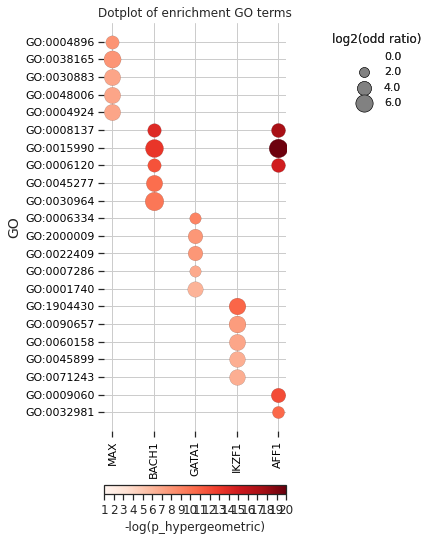

In [73]:
fig = plt.figure(figsize=(15, 10))
p_val,odd_ratio = dotplot(test,annpath="../../annotation/",fig=fig)

In [75]:
a = {
    1 : pd.DataFrame({"test":["AFF1_MV4-11","AFF1_MV4-11"]}),
    2 : pd.DataFrame({"test":["2","2"]}),
}
a[1]

,test
0,AFF1_MV4-11
1,AFF1_MV4-11


In [70]:
[i for i in range(round(5),round(7)+1)]

[5, 6, 7]